# 1 Imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from pmdarima.arima.utils import ndiffs, nsdiffs
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from ev_load_fc.config import CFG, resolve_path
from ev_load_fc.training.evaluation import sarimax_one_step

feature_store = resolve_path(CFG["paths"]["feature_store"])
split_date    = pd.to_datetime(CFG["data"]["preprocessing"]["split_date"])
X             = pd.read_csv(feature_store / "X.csv", parse_dates=['timestamp'], index_col='timestamp')
y             = pd.read_csv(feature_store / "y.csv", parse_dates=['timestamp'], index_col='timestamp')
X_train       = X[X.index <  split_date].copy()
y_train       = y[y.index <  split_date].copy()
X_test        = X[X.index >= split_date].copy()
y_test        = y[y.index >= split_date].copy()

# 2 Naive model

Since the 168 lag for energy had the highest F-statistic and mutial information score, we will use it as a naive model to provide a benchmark for more advanced models.

In [2]:
seaonal_naive_train = X_train['energy_lag_168']
seaonal_naive_test  = X_test['energy_lag_168']

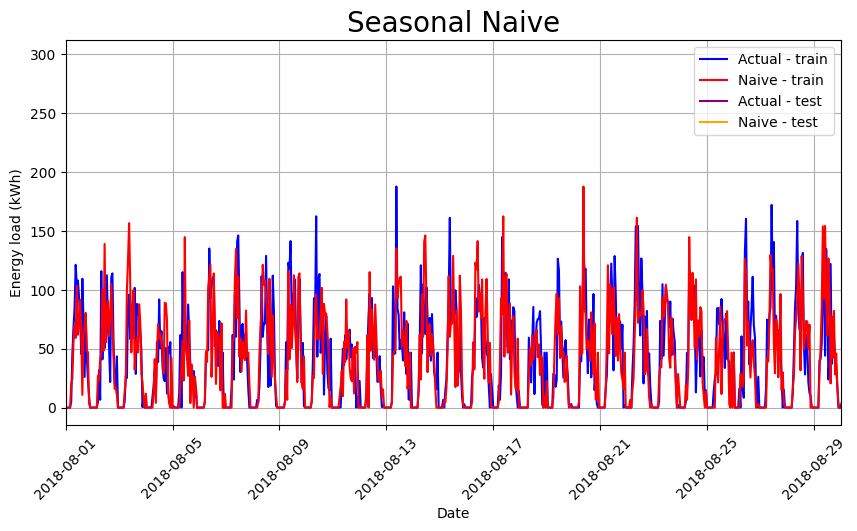

In [3]:
eval_min = datetime(2018,8,1)
eval_max = datetime(2018,8,30)

fig = plt.figure(figsize=(10,5))
plt.title('Seasonal Naive', fontsize=20)
plt.plot(y_train, label='Actual - train', color='blue')
plt.plot(seaonal_naive_train, label='Naive - train', color='red')
plt.plot(y_test, label='Actual - test', color='purple')
plt.plot(seaonal_naive_test, label='Naive - test', color='orange')
plt.xlim(eval_min, eval_max) 
plt.legend()
plt.xlabel('Date')
plt.ylabel('Energy load (kWh)')
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [4]:
# Average load for train set
naive_train_mean = y_train.mean(axis=0).iloc[0]
print(f'Mean train energy load (kWh): {naive_train_mean:.2f}')
# Seasonal Naive MAE for train set
naive_train_mae = mean_absolute_error(y_train, seaonal_naive_train)
print(f'Naive train MAE (kWh): {naive_train_mae:.2f}')
# Seasonal Naive RMSE for train set
naive_rmse = root_mean_squared_error(y_train, seaonal_naive_train)
print(f'Naive train RMSE (kWh): {naive_rmse:.2f}')

Mean train energy load (kWh): 41.69
Naive train MAE (kWh): 21.59
Naive train RMSE (kWh): 33.06


In [5]:
# Average load for test set
naive_test_mean = y_test.mean(axis=0).iloc[0]
print(f'Mean test energy load (kWh): {naive_test_mean:.2f}')
# Seasonal Naive MAE for test set
naive_test_mae = mean_absolute_error(y_test, seaonal_naive_test)
print(f'Naive test MAE (kWh): {naive_test_mae:.2f}')
# Seasonal Naive RMSE for test set
naive_rmse = root_mean_squared_error(y_test, seaonal_naive_test)
print(f'Naive test RMSE (kWh): {naive_rmse:.2f}')

Mean test energy load (kWh): 53.56
Naive test MAE (kWh): 27.05
Naive test RMSE (kWh): 40.96


# 3 (S)ARIMA

## Estimate optimal differencing orders

In [2]:
# Optimal differencing order d
nd_adf = ndiffs(y_train, test='adf')  
print(f"Recommended differencing order: {nd_adf}")

# Optimal seasonal differencing order D for weekly seasonality
nd_w_seasonal_adf = nsdiffs(y_train,  m=168,  max_D=2, test='ch')  
print(f"Recommended weekly seasonal differencing order: {nd_w_seasonal_adf}")
# Optimal seasonal differencing order D for daily seasonality
nd_d_seasonal_adf = nsdiffs(y_train,  m=24,  max_D=2, test='ch')  
print(f"Recommended daily seasonal differencing order: {nd_d_seasonal_adf}")

Recommended differencing order: 0
Recommended weekly seasonal differencing order: 0
Recommended daily seasonal differencing order: 1


## Fit model

In [2]:
sa_daily_model = SARIMAX(
    endog=y_train, 
    order=(1,0,1),
    seasonal_order=(1,1,1,24),
    freq='h'
    )
sa_daily_fitted = sa_daily_model.fit()
print(sa_daily_fitted.summary())

c:\Users\Cameron\projects\ev_load_fc\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                             energy   No. Observations:                17352
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 24)   Log Likelihood              -81117.238
Date:                            Wed, 31 Dec 2025   AIC                         162244.477
Time:                                    09:54:32   BIC                         162283.277
Sample:                                08-08-2017   HQIC                        162257.260
                                     - 07-31-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8388      0.011     76.145      0.000       0.817       0.860
ma.L1         -0.6798      0.014   

## Plot predictions

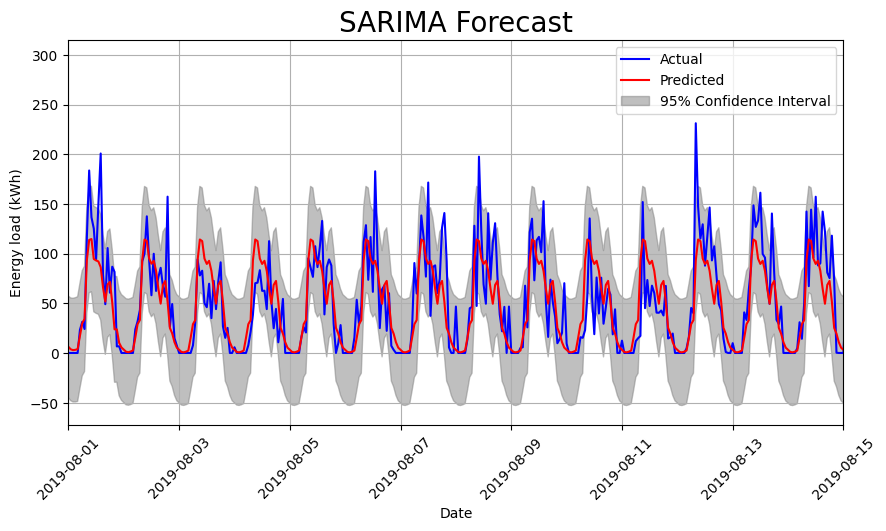

In [4]:
sa_forecast = sa_daily_fitted.get_prediction(start=len(y_train), end=len(y_train)+len(y_test))
sa_forecast_mean = sa_forecast.predicted_mean
conf_int = sa_forecast.conf_int()
eval_min = datetime(2019,8,1)
eval_max = datetime(2019,8,15)
dates = pd.date_range(start='2019-08-01', periods=len(y_test), freq='h')

fig = plt.figure(figsize=(10,5))
plt.title('SARIMA Forecast', fontsize=20)
plt.plot(y_test.index, y_test['energy'], label='Actual', color='blue')
plt.plot(sa_forecast_mean.index, sa_forecast_mean.values, label='Predicted', color='red')
plt.fill_between(
    dates, 
    conf_int.iloc[:-1]['lower energy'], 
    conf_int.iloc[:-1]['upper energy'], 
    color='gray', 
    alpha=0.5, 
    label='95% Confidence Interval'
)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Energy load (kWh)')
plt.xticks(rotation=45)
plt.xlim(eval_min, eval_max) 
plt.grid()
plt.show()

## Score

In [5]:
# Average load for test set
naive_test_mean = y_test.mean(axis=0).iloc[0]
print(f'Mean test energy load (kWh): {naive_test_mean:.2f}')
# Seasonal SARIMA MAE for test set
sarima_test_mae = mean_absolute_error(y_test, sa_forecast_mean[:-1])
print(f'SARIMA test MAE (kWh): {sarima_test_mae:.2f}')
# Seasonal SARIMA RMSE for test set
sarima_rmse = root_mean_squared_error(y_test, sa_forecast_mean[:-1])
print(f'SARIMA test RMSE (kWh): {sarima_rmse:.2f}')

Mean test energy load (kWh): 53.56
SARIMA test MAE (kWh): 23.78
SARIMA test RMSE (kWh): 34.93


In [ ]:
mean_one_step_rsme = sarimax_one_step(sa_daily_fitted, y_test=y_test, start=y_test.index.min, end=y_test.index.max)

# 4 Exponential smoothing (Holt-Winters)

## Fit model

In [2]:
fit_hw = ExponentialSmoothing(
    endog=y_train,
    seasonal_periods=24,
    trend="add",
    seasonal="add",
    initialization_method="estimated",
).fit()

fit_hw.params

c:\Users\Cameron\projects\ev_load_fc\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


{'smoothing_level': np.float64(0.08735642378735836),
 'smoothing_trend': np.float64(0.0),
 'smoothing_seasonal': np.float64(0.01928039991695395),
 'damping_trend': nan,
 'initial_level': np.float64(38.96638813315249),
 'initial_trend': np.float64(0.0008649828707661325),
 'initial_seasons': array([-34.71342636, -33.51758322, -33.77473502, -33.70799645,
        -33.10622559, -26.31918646,  -7.98362416,   9.19919454,
         14.24669095,  31.71702861,  37.28628082,  27.84098472,
         31.71041637,  23.4138637 ,  25.63312018,  17.80077147,
          9.87977732,  22.05735812,  30.10186164,   8.43416413,
         -9.137682  , -20.46472777, -24.53887454, -32.23415048]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

## Plot predictions

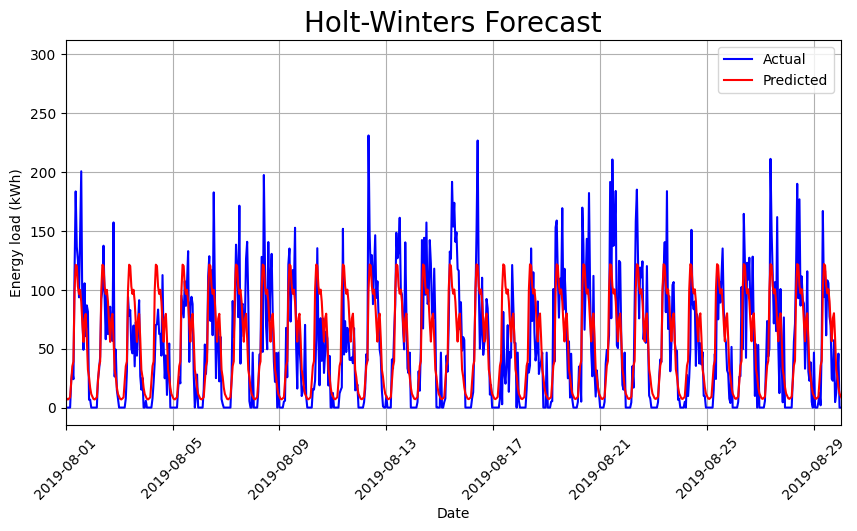

In [ ]:
# predict using the datetime index of the test set
hw_preds = fit_hw.predict(start=y_test.index[0], end=y_test.index[-1])

eval_min = datetime(2019,8,1)
eval_max = datetime(2019,8,30)

fig = plt.figure(figsize=(10,5))
plt.title('Holt-Winters Forecast', fontsize=20)
plt.plot(y_test.index, y_test['energy'], label='Actual', color='blue')
plt.plot(hw_preds.index, hw_preds.values, label='Predicted', color='red')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Energy load (kWh)')
plt.xticks(rotation=45)
plt.xlim(eval_min, eval_max) 
plt.grid()
plt.show()

In [ ]:
# Average load for test set
naive_test_mean = y_test.mean(axis=0).iloc[0]
print(f'Mean test energy load (kWh): {naive_test_mean:.2f}')
# Holt-Winters exponential smoothing MAE for test set
hwes_test_mae = mean_absolute_error(y_test, hw_preds)
print(f'Holt-Winters test MAE (kWh): {hwes_test_mae:.2f}')
# Holt-Winters exponential smoothing RMSE for test set
hwes_rmse = root_mean_squared_error(y_test, hw_preds)
print(f'Holt-Winters test RMSE (kWh): {hwes_rmse:.2f}')

Mean test energy load (kWh): 53.56
SARIMA test MAE (kWh): 25.62
Holt-Winters test RMSE (kWh): 34.43
